# Interacting with CLIP

[CLIP paper](https://arxiv.org/abs/2103.00020)

![CLIP objective](https://github.com/openai/CLIP/raw/main/CLIP.png)

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [45]:
# ! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\hp\appdata\local\temp\pip-req-build-g3r4gqu6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-g3r4gqu6'


In [46]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.4.1+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [47]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, preprocess = clip.load("ViT-B/16")
model = model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [49]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001877E3635E0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [50]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [51]:
import os
import skimage
from skimage import data
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "cat": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
    "eagle": "a black-and-white photo of an eagle"
}

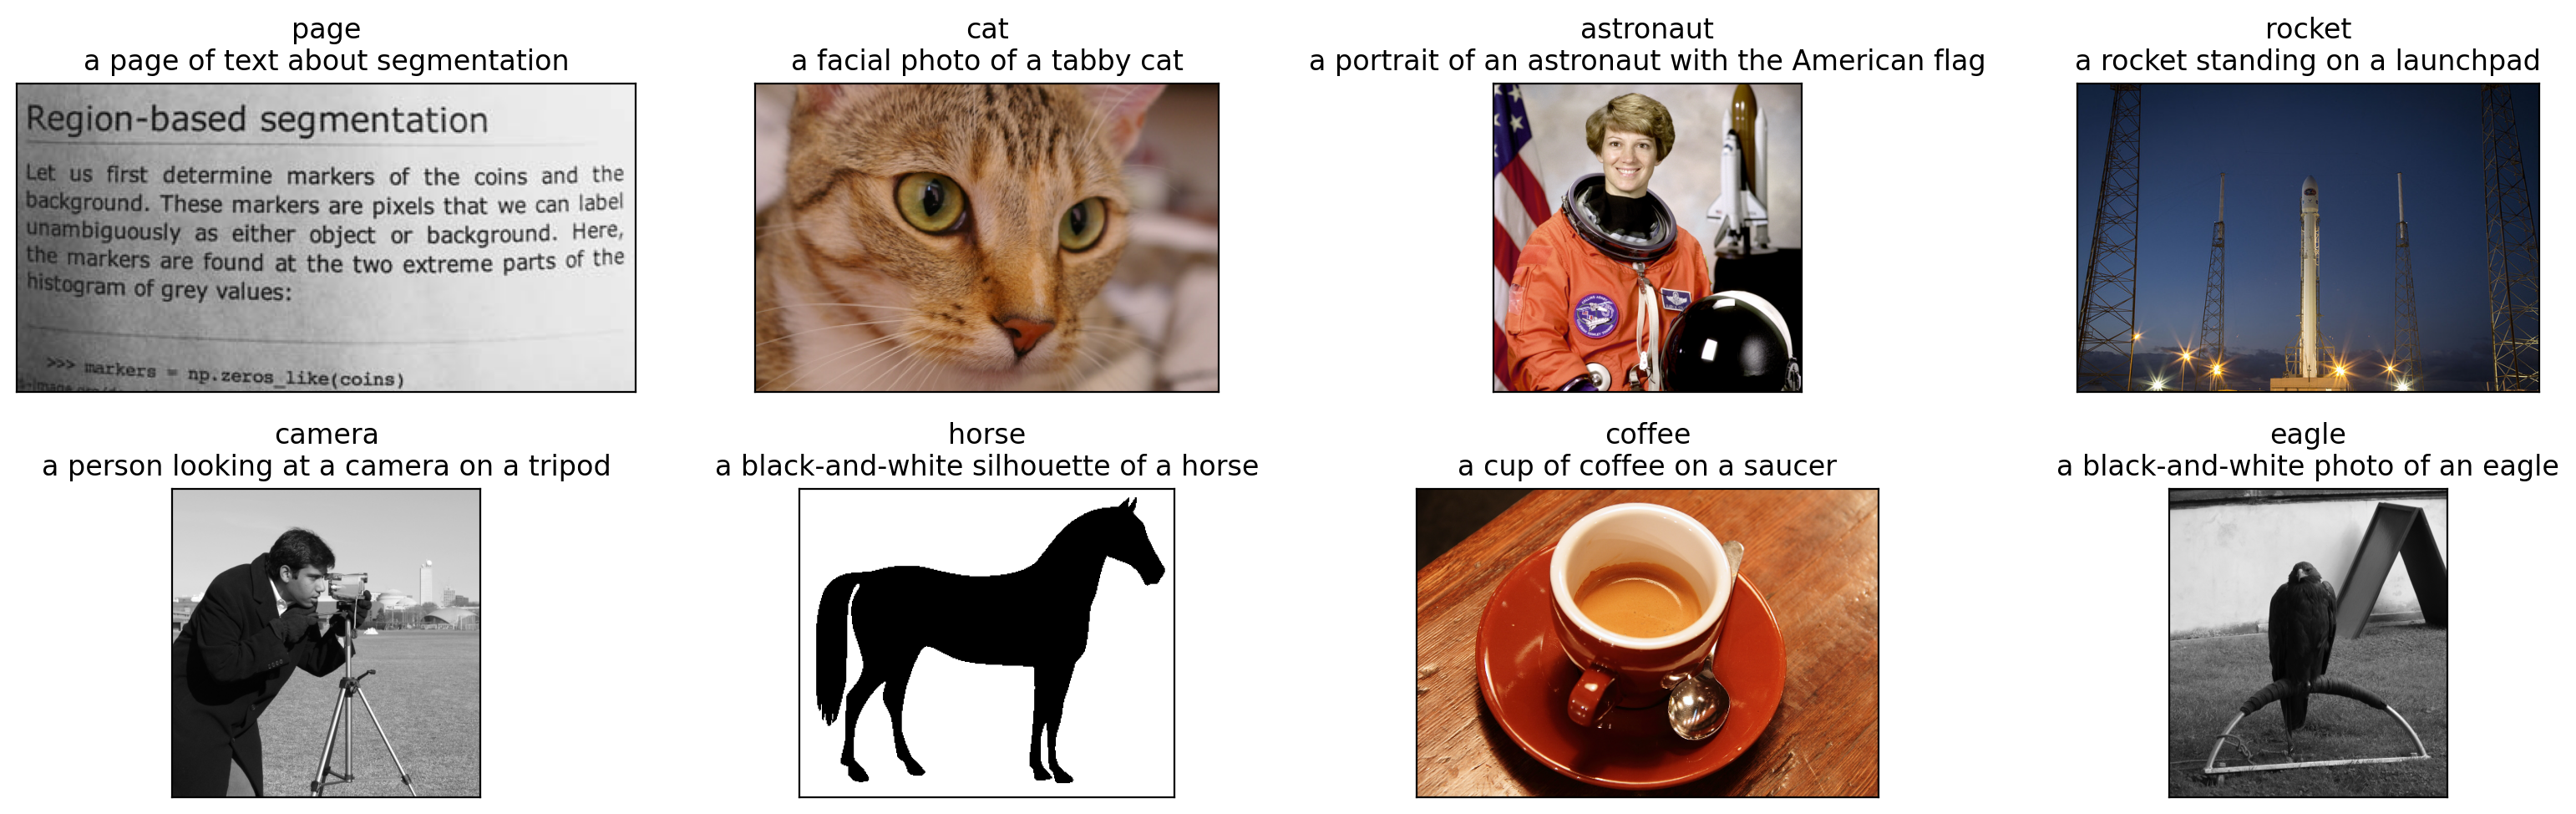

In [52]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for name in descriptions:
    caller = getattr(data, name)
    image = caller()
    image = Image.fromarray(image).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{name}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [53]:
print(images[0].shape)

torch.Size([3, 224, 224])


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [54]:
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)

In [55]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [56]:
print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

$$\text{Normalize}(x) = \frac{x}{||x||}$$

$$\text{cos}(x, y) = \frac{x \cdot y}{||x|| ||y||}$$

In [57]:
image_features = image_features / torch.norm(image_features, dim=1, keepdim=True)
text_features = text_features / torch.norm(text_features, dim=1, keepdim=True)

similarity = torch.matmul(image_features, text_features.T).cpu().numpy()

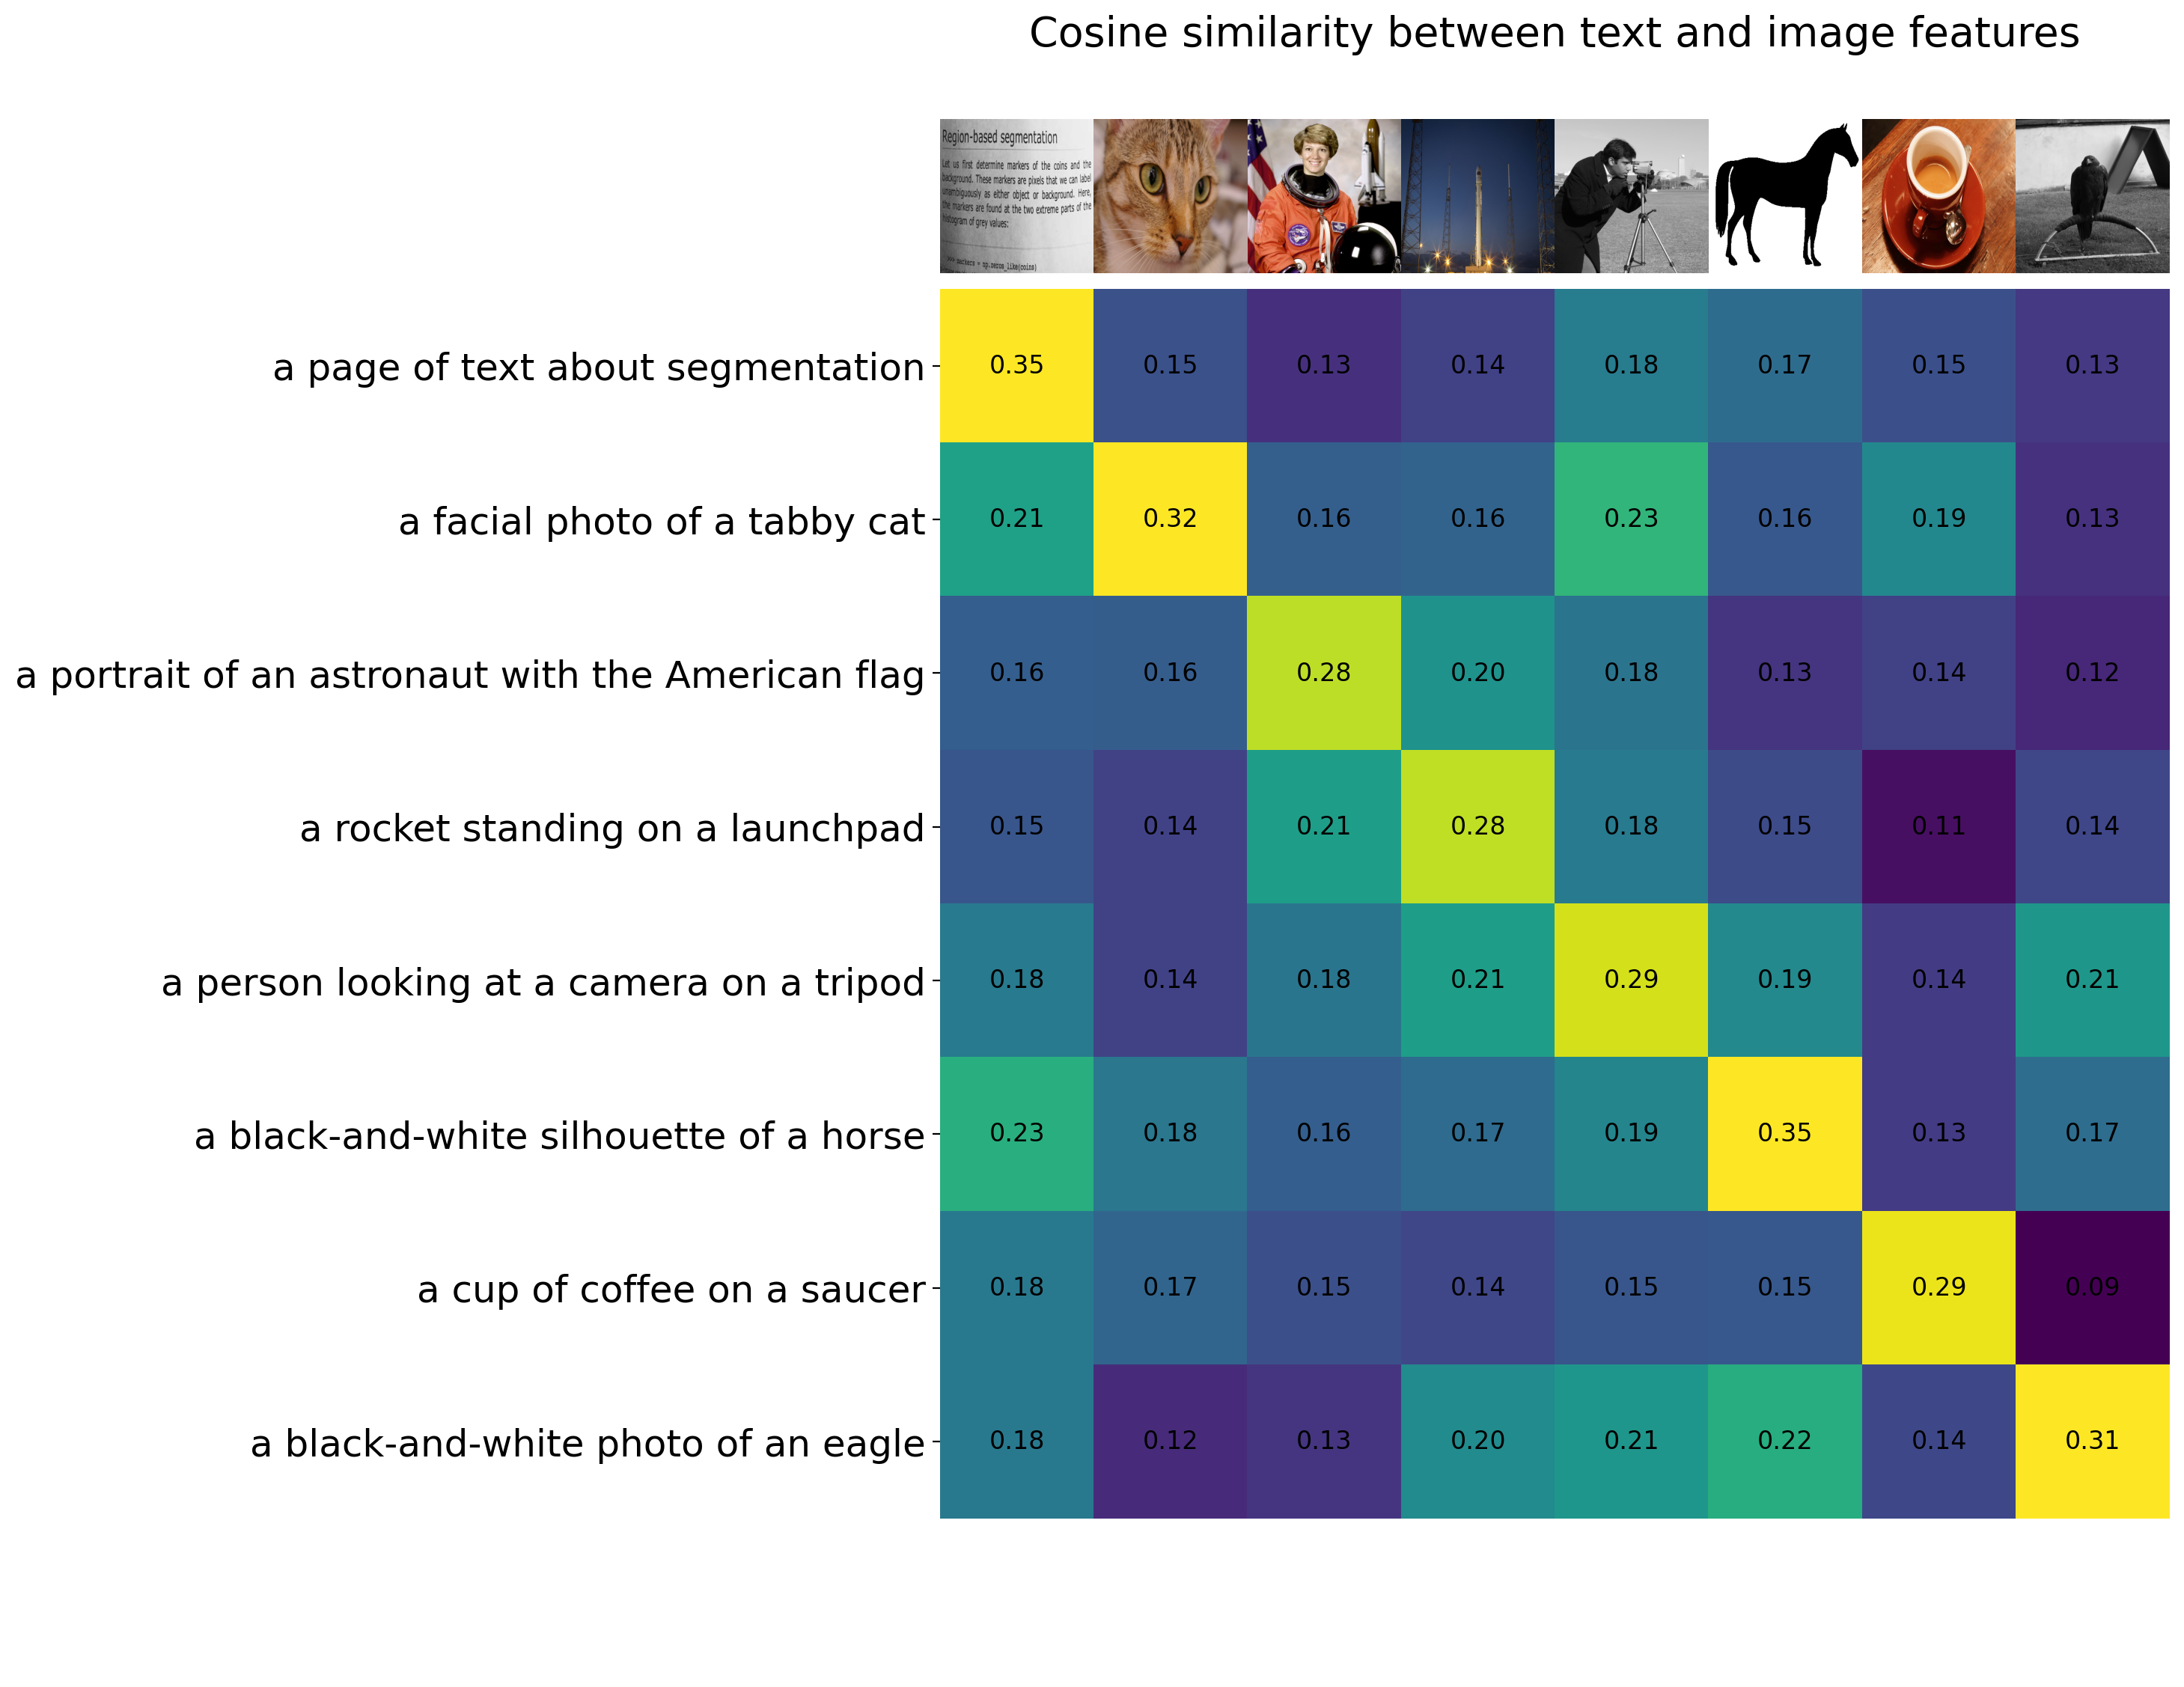

In [58]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.show()

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [59]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100('D:/data', transform=preprocess, download=True)

Files already downloaded and verified


In [60]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [61]:
print(cifar100.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [62]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

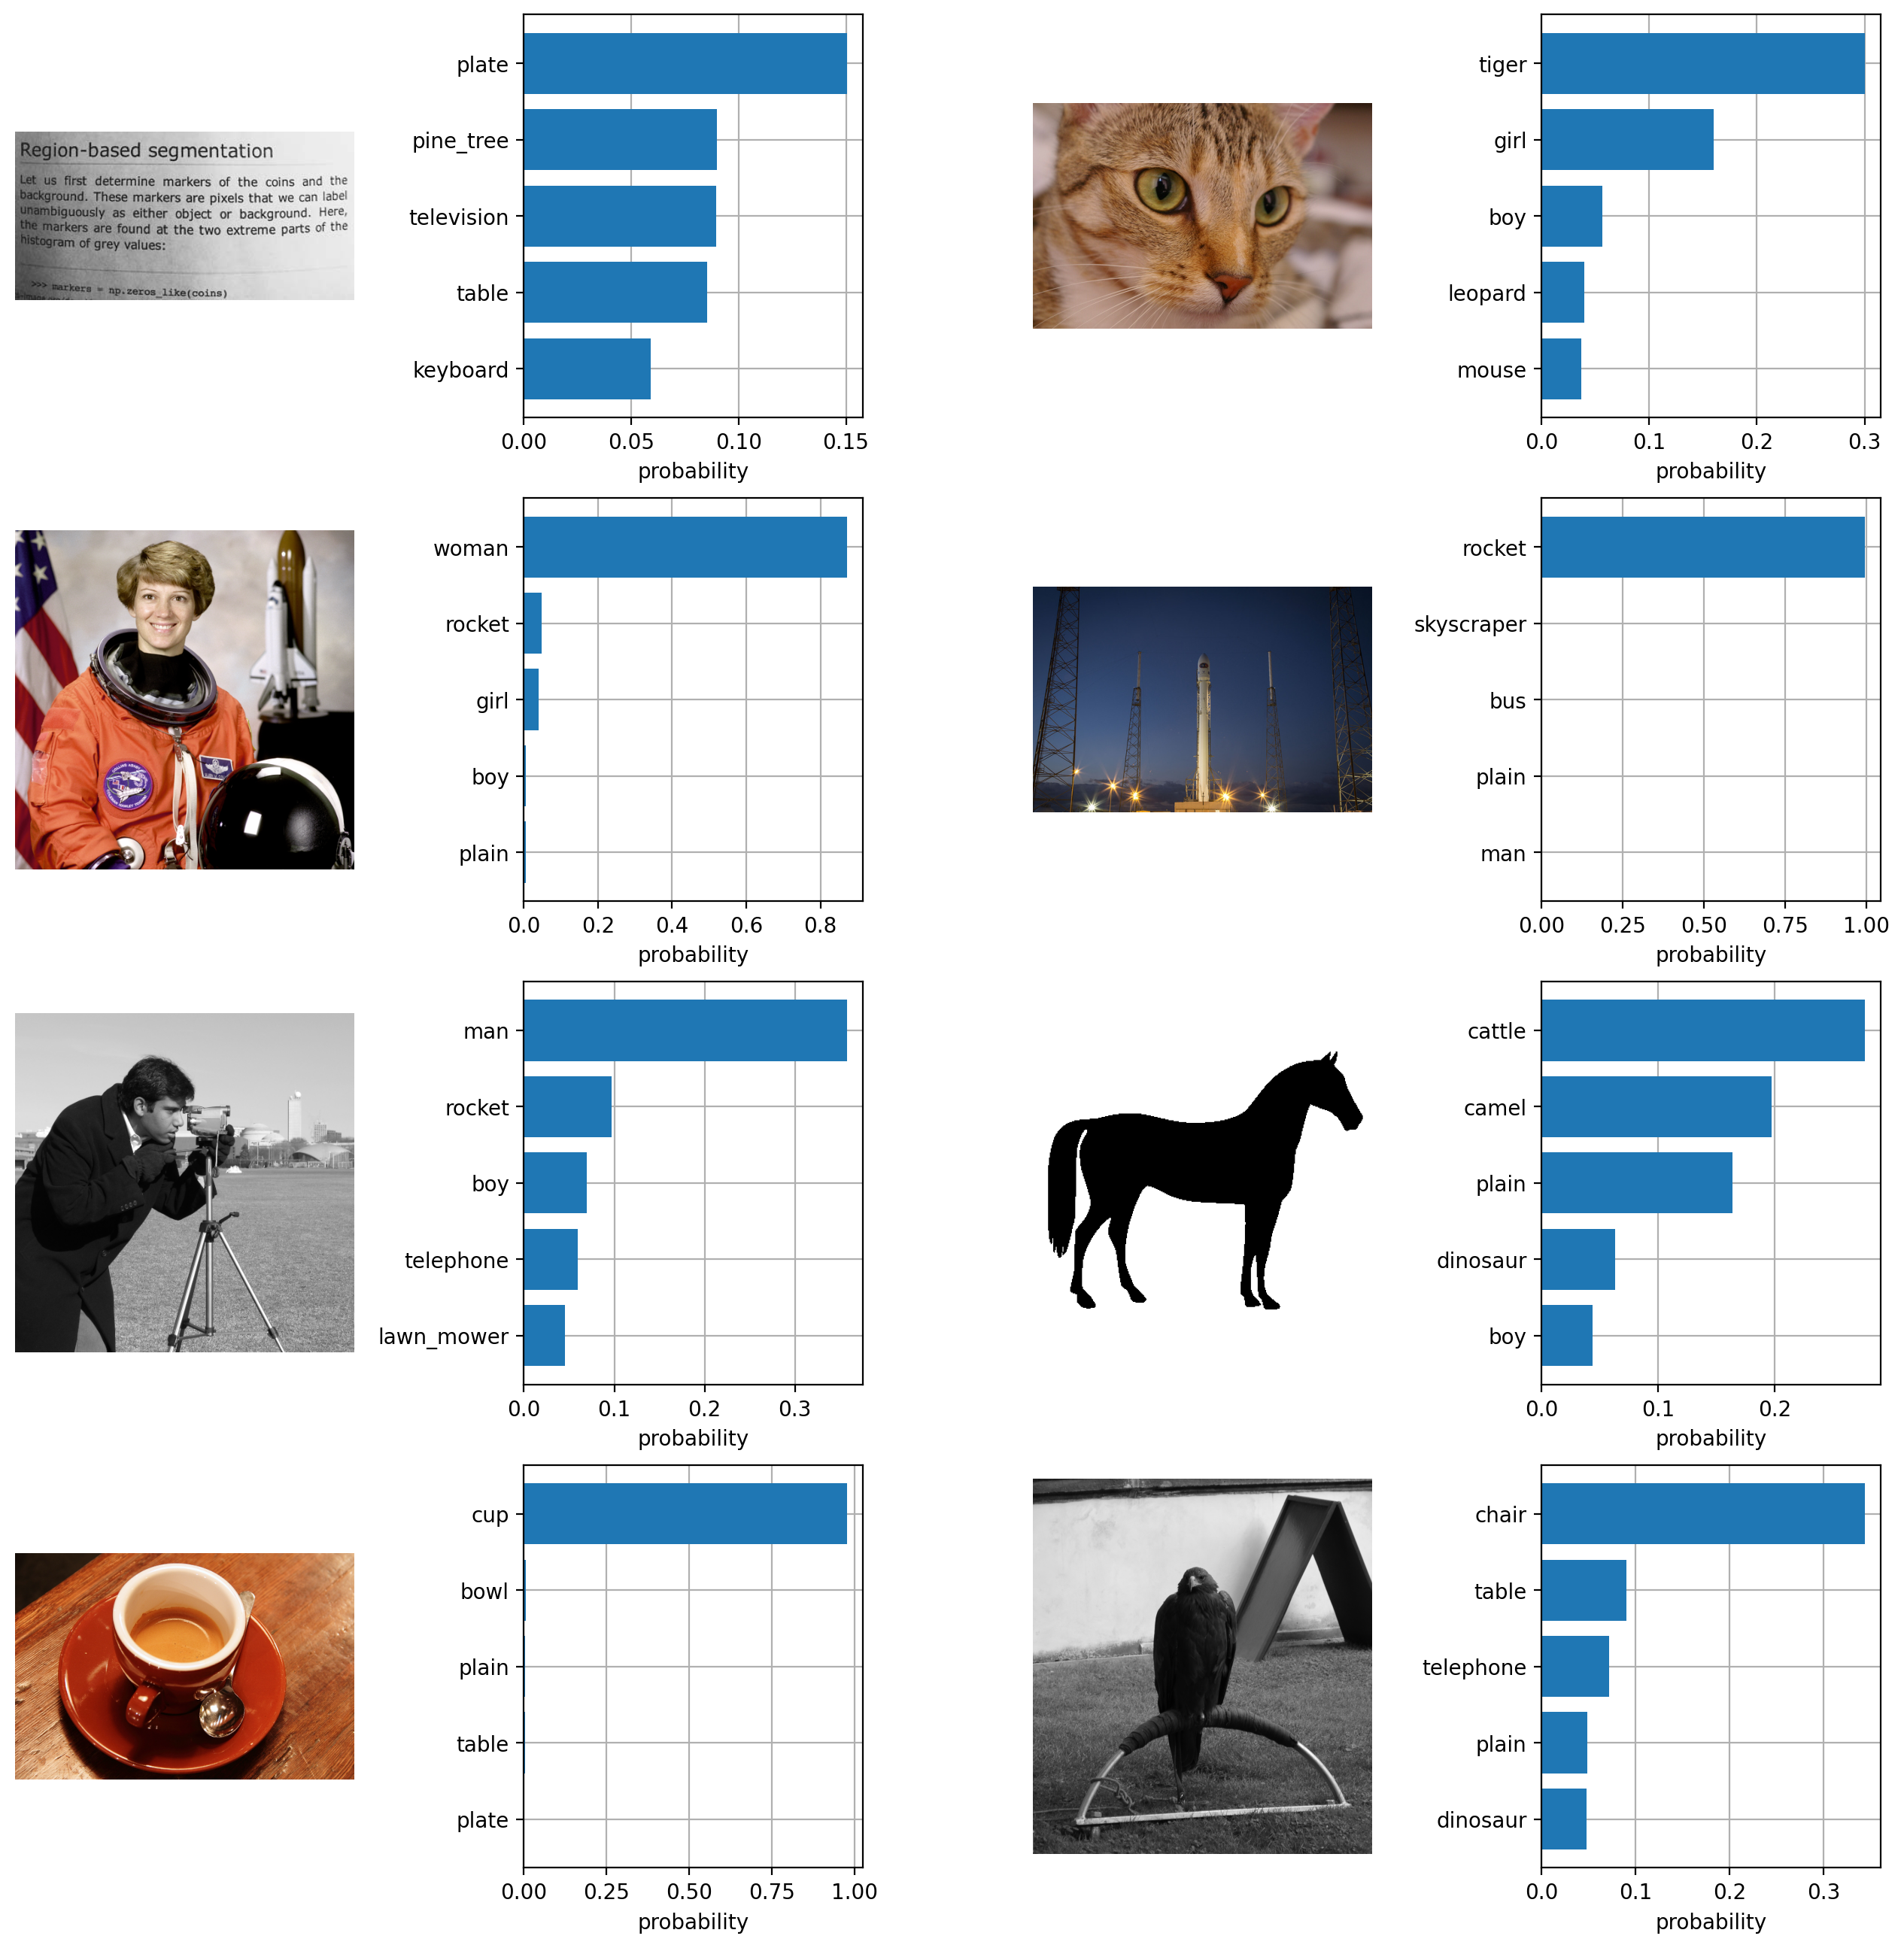

In [63]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

#### Try your own images

In [78]:
import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download {url}")

download_file("https://heronscrossing.vet/wp-content/uploads/Golden-Retriever-2048x1365.jpg", "Golden-Retriever.jpg")
download_file("https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg/224px-Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg", "Orange_tabby_cat.jpg")


Downloaded: Golden-Retriever.jpg
Downloaded: Orange_tabby_cat.jpg


In [81]:
# load image and get image feature
orig_image = Image.open("Golden-Retriever.jpg").convert("RGB")

# TODO
# preprocess image, then convert to shape (1, 3, 224, 224) and move it to device
image = preprocess(orig_image).unsqueeze(0).to(device)


# TODO
# extract image features and normalize
with torch.no_grad():
    image_features = model.encode_image(image).float()
    image_features /= image_features.norm(dim=1, keepdim=True)


print(image_features.shape)

torch.Size([1, 512])


In [82]:
# text features
classes = ['dog', 'cat']
text_descriptions = [f"This is a photo of a {label}" for label in classes]

# TODO
# tokenize and move to device
text_tokens = clip.tokenize(text_descriptions).to(device)

# TODO
# extract text features and normalize
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_features.shape)

torch.Size([2, 512])


In [86]:
# TODO
# compute probability for each class
class_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

In [87]:
print(class_probs)

tensor([[9.9967e-01, 3.3221e-04]], device='cuda:0')


In [88]:
print('Classification Result')
for ix, label in enumerate(classes):
    print(f"{label}: {class_probs[0][ix] * 100:.2f}%")

Classification Result
dog: 99.97%
cat: 0.03%


In [ ]:
# feel free to try your own image
# and also try changing classes

## Evaluating CLIP on Zero-Shot Image Classification

In [114]:
# We will evaluate CLIP on conventional image classification dataset (CIFAR10)

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm

cifar10 = CIFAR10('D:/data', transform=preprocess, download=True, train=False)

test_loader = DataLoader(cifar10, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified


In [115]:
print(cifar10.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [116]:
# Preparing text features of 10 classes

text_descriptions = [f"This is a photo of a {label}" for label in cifar10.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [120]:

correct = 0
total = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)

    # TODO: extract image features, compute prediction, and compute accuracy
    with torch.no_grad():
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=1, keepdim=True)

    prediction = (image_features @ text_features.T).argmax(dim=1)
    correct += (prediction == labels).sum().item()
    total += len(labels)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]

Accuracy: 87.26%


### Prompt Tuning to Improve Zero-Shot Classification

In [121]:
templates = [
        "a photo of a {c}.",
        "a blurry photo of a {c}.",
        "a black and white photo of a {c}.",
        "a low contrast photo of a {c}.",
        "a high contrast photo of a {c}.",
        "a bad photo of a {c}.",
        "a good photo of a {c}.",
        "a photo of a small {c}.",
        "a photo of a big {c}.",
        "a photo of the {c}.",
        "a blurry photo of the {c}.",
        "a black and white photo of the {c}.",
        "a low contrast photo of the {c}.",
        "a high contrast photo of the {c}.",
        "a bad photo of the {c}.",
        "a good photo of the {c}.",
        "a photo of the small {c}.",
        "a photo of the big {c}."
    ]

In [122]:


text_features = []
for classname in cifar10.classes:
    text_descriptions = [template.format(c=classname) for template in templates]
    text_tokens = clip.tokenize(text_descriptions).to(device)
    with torch.no_grad():
        class_text_features = model.encode_text(text_tokens).float()
        class_text_features /= class_text_features.norm(dim=-1, keepdim=True)

        class_text_feature = class_text_features.mean(dim=0)
        class_text_feature /= class_text_feature.norm(dim=-1, keepdim=True)
    text_features.append(class_text_feature)

text_features = torch.stack(text_features, dim=0)

In [123]:

correct = 0
total = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)

    # TODO: extract image features, compute prediction, and compute accuracy
    with torch.no_grad():
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=1, keepdim=True)

    prediction = (image_features @ text_features.T).argmax(dim=1)
    correct += (prediction == labels).sum().item()
    total += len(labels)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 100/100 [00:19<00:00,  5.02it/s]

Accuracy: 88.58%
